In [1]:
import numpy as np
import scipy as sp
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
import sys, copy, emcee, corner
%matplotlib inline

In [90]:
def dilser(low=0.001, limit=100., dilfactor=2.):
    '''returns a numpy array dilution series from low to limit by dilfactor'''
    #replace this with a generator/iterator someday
    a = [low]
    while a[-1] <= limit:
        a.append(a[len(a)-1]*dilfactor)
    return np.array(a)

def k1mod(params,ligs,noise=None):
    '''
    theoretical model for single binding site
    
    returns tuple of ligand concentrations, saturation, params

    params is array of binding constants
    ligs is array of ligand concentrations
    noise is relative percent of gaussian noise (e.g., 0.0-1.) applied to data
    '''

    k1 = params[0]
    sat = (k1*ligs)/(1 + k1*ligs)

    if noise is None:
        return (ligs,sat)
    else:
        noised = np.random.normal(sat,noise*sat)
        return (ligs,noised,params)

def k2mod(params,ligs,noise=None):
    '''
    theoretical model for a two-site receptor
    
    returns tuple of ligand concentrations, saturation, params

    params is array of binding constants
    ligs is array of ligand concentrations
    noise is relative percent of gaussian noise (e.g., 0.0-1.) applied to data
    '''

    k1 = params[0]
    k2 = params[1]
    sat = (1/2)*((k1*ligs + 2*k1*k2*(ligs**2))/(1 + k1*ligs + k1*k2*(ligs**2)))

    if noise is None:
        return (ligs,sat)
    else:
        noised = np.random.normal(sat,noise*sat)
        return (ligs,noised,params)

def k2mod_fix(params,ligs,noise=None):
    '''
    returns tuple of ligand concentrations, saturation, params

    params is array of binding constants
    ligs is array of ligand concentrations
    noise is relative percent of gaussian noise (e.g., 0.0-1.) applied to data
    '''

    k1 = params[0]
    k2 = params[0]/4
    sat = (1/2)*((k1*ligs + 2*k1*k2*(ligs**2))/(1 + k1*ligs + k1*k2*(ligs**2)))

    if noise is None:
        return (ligs,sat)
    else:
        noised = np.random.normal(sat,noise*sat)
        return (ligs,noised,params)

def obj(guess,model,data):
    return model(guess,data[0])[1] - data[1]

#removed proportionality constant
def obj_wt(guess,model,data):
    return (model(guess,data[0])[1] - data[1])/(data[1])

def fit(data,model,guess):
        return sp.optimize.least_squares(obj,guess,args=(model,data),ftol=1e-14,gtol=1e-14,xtol=1e-14)

#removed proportionality constant    
def fit_wt(data,model,guess):
        return sp.optimize.least_squares(obj_wt,guess,args=(model,data),ftol=1e-14,gtol=1e-14,xtol=1e-14)

def ftest(fit1,fit2):
    '''
    fit1 is fit from simpler model
    '''

    SS1 = np.sum(np.square(fit1.fun))
    SS2 = np.sum(np.square(fit2.fun))

    DF1 = fit1.fun.shape[0] - fit1.x.shape[0]
    DF2 = fit2.fun.shape[0] - fit2.x.shape[0]

    F = ((SS1-SS2)/(DF1-DF2))/(SS2/DF2)

    p = sp.stats.f.sf(F,(DF1-DF2),DF2)

    return (SS1,SS2,DF1,DF2,F,p)

In [3]:
ligs = dilser()

In [4]:
k1parm = np.array([1.])

In [74]:
k1datset = [k1mod(k1parm,ligs,0.1) for i in range(10000)]

In [75]:
k2guess = np.array([2.,0.5])
k2fixguess = np.array([2.])

In [76]:
k2fits = [fit(i,k2mod,k2guess) for i in k1datset]

In [77]:
k1fits_nested = [fit(i,k2mod_fix,k2fixguess) for i in k1datset]

In [78]:
np.sum(np.array([i.x[0]/i.x[1] for i in k2fits]) > 6)

2184

In [79]:
k2full = np.array([i.x[0] for i in k2fits])
k2nest = np.array([i.x[0] for i in k1fits_nested])

(array([  3.80000000e+01,   3.06000000e+02,   1.33000000e+03,
          2.64600000e+03,   2.91800000e+03,   1.86600000e+03,
          7.12000000e+02,   1.64000000e+02,   1.90000000e+01,
          1.00000000e+00]),
 array([ 1.24827343,  1.42604779,  1.60382216,  1.78159653,  1.95937089,
         2.13714526,  2.31491963,  2.49269399,  2.67046836,  2.84824273,
         3.02601709]),
 <a list of 10 Patch objects>)

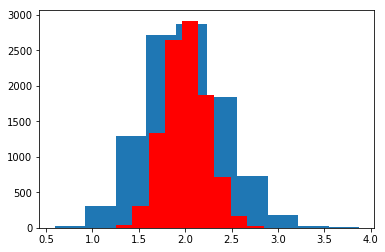

In [80]:
plt.hist(k2full)
plt.hist(k2nest,color='red')

In [93]:
ps = np.array([ftest(k1fits_nested[i],k2fits[i])[-1] for i in range(10000)])

In [94]:
ps[0]

0.40220911298094542

In [83]:
ps.mean()

0.47532876823248543

In [95]:
k2fits[(ps < 0.05)]

TypeError: only integer scalar arrays can be converted to a scalar index

In [96]:
ftz = np.array(k2fits)

In [97]:
wins = ftz[(ps < 0.05)]

In [98]:
ratios = np.array([i.x[0]/i.x[1] for i in wins])

In [99]:
np.sum(ratios > 4)

420